In [22]:
import numpy as np
import matplotlib.pyplot as plt

In [23]:
def original_objective(Q, p, v):
    return v.T @ Q @ v + p.T @ v

In [24]:
def barrier_objective(Q, p, A, b, t, v):
    
    residual = b - A @ v
    if np.any(residual <= 0):
        return np.inf  # Return infinity if the point is infeasible
    
    # Barrier term
    barrier_term = -np.sum(np.log(residual)) / t
    
    # Barrier objective function
    f = t * original_objective(Q, p, v) + barrier_term
    return f

In [25]:
def centering_step(Q, p, A, b, t, v0, eps, alpha=0.1, beta=0.5):
    v = v0
    v_seq = [v0]

    while True:
        # Compute gradient & Hessian
        residual = b - A @ v
        gradient = t * (Q + Q.T) @ v + t * p + A.T @ (1 / residual)
        hessian = t * (Q + Q.T) + A.T @ np.diag(1 / residual**2) @ A

        # Compute Newton step & decrement
        newton_step = np.linalg.solve(hessian, - gradient)
        newton_decrement = - gradient.T @ newton_step

        # Break condition for centering step
        if newton_decrement / 2 <= eps:
            break

        # Backtracking line search
        s = 1
        current_obj = barrier_objective(Q, p, A, b, t, v)
        # Break condition for backtracking line search step
        while barrier_objective(Q, p, A, b, t, v + s * newton_step) > current_obj + alpha * s * gradient.T @ newton_step:
            s *= beta
        
        # Keep track of updated v values
        v = v + s * newton_step
        v_seq.append(v)
    
    return v_seq

In [26]:
def barr_method(Q, p, A, b, v0, eps, t=1, mu=10):
    v = v0
    v_seq = []
    m = b.size

    while True:
        # Run centering step for current v
        v_center_seq = centering_step(Q, p, A, b, t, v, eps)

        # Keep last value v obtained via centering step
        if len(v_center_seq) > 0:
            v = v_center_seq[-1]
            v_seq.append(v)

        # Break condition for barrier method
        if m / t < eps:
            break
        
        # Increase t by factor mu
        t *= mu
    
    return v_seq

Running Barrier Method with mu = 2
Running Barrier Method with mu = 15
Running Barrier Method with mu = 50
Running Barrier Method with mu = 100
Running Barrier Method with mu = 200
Running Barrier Method with mu = 500


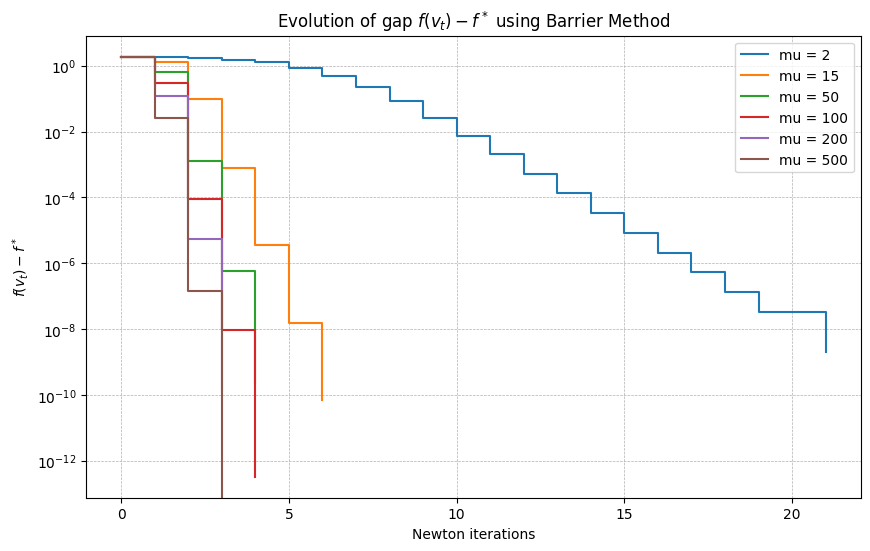

In [27]:
# Initialization of parameters
lam = 10
mus = [2, 15, 50, 100, 200, 500]
n = 10
d = 10000

X = np.random.uniform(-1, 1, (n, d))
y = np.random.uniform(-1, 1, n)

# Reformulating problem to general QP
Q = 0.5 * np.identity(n)
p = -y
A = np.vstack([X.T, -X.T])
b = np.full(2*d, lam)
eps = 0.01

# Check if v0 satisfies the feasibility condition A @ v0 <= b
v0 = np.zeros(n)
while not np.all(A @ v0 <= b):
    v0 = np.random.uniform(-1, 1, n)

all_results = {}
f_star = np.inf

# Run barrier method for different values of mu
for mu in mus:
    print(f"Running Barrier Method with mu = {mu}")
    v_seq = barr_method(Q, p, A, b, v0, eps, mu=mu)
    f_values = [original_objective(Q, p, v) for v in v_seq]
    
    all_results[mu] = f_values

    # Keep track of minimal value found for objective function f0 (f^*)
    f_star = min(f_star, min(f_values))

# Plot evolution of gap for different values of mu using matplotlib
plt.figure(figsize=(10, 6))

for mu, f_values in all_results.items():
    gaps = [f - f_star for f in f_values]
    plt.step(range(len(gaps)), gaps, label=f'mu = {mu}', where='post')

plt.yscale('log')
plt.xlabel('Newton iterations')
plt.ylabel(r'$f(v_t) - f^*$')
plt.title('Evolution of gap $f(v_t) - f^*$ using Barrier Method')
plt.legend()
plt.grid(True, which="both", linestyle='--', linewidth=0.5)

plt.show()